## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext line_profiler

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [ ]:
import time
import re
import warnings
import winsound
from pathlib import Path
from pprint import pprint
from tqdm import tqdm
from afml.mt5.load_data import load_tick_data, load_training_data, get_ticks, login_mt5
import MetaTrader5 as mt5

from afml.util.misc import date_conversion

import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
)
from sklearn.tree import DecisionTreeClassifier

from afml.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    analyze_cross_val_scores,
    probability_weighted_accuracy,
    analyze_cross_val_scores,
)
from afml.data_structures.bars import *
from afml.ensemble.sb_bagging import (
    SequentiallyBootstrappedBaggingClassifier,
    compute_custom_oob_metrics,
    estimate_ensemble_size,
)
from afml.labeling.triple_barrier import (
    add_vertical_barrier,
    get_event_weights,
    triple_barrier_labels,
)
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)

# from afml.sampling import get_ind_mat_average_uniqueness, get_ind_matrix, seq_bootstrap
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
    ForexFeatureEngine,
)
from afml.util import get_daily_vol, value_counts_data
from afml.cache import get_cache_efficiency_report, print_cache_health, clear_afml_cache, clear_cv_cache

warnings.filterwarnings("ignore")
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("dark_background")

2025-11-09 21:40:42.585 | DEBUG    | afml.cache:<module>:619 - Enhanced cache features available:
2025-11-09 21:40:42.587 | DEBUG    | afml.cache:<module>:620 -   - Robust cache keys for NumPy/Pandas
2025-11-09 21:40:42.588 | DEBUG    | afml.cache:<module>:621 -   - MLflow integration: ✓
2025-11-09 21:40:42.591 | DEBUG    | afml.cache:<module>:622 -   - Backtest caching: ✓
2025-11-09 21:40:42.592 | DEBUG    | afml.cache:<module>:623 -   - Cache monitoring: ✓
2025-11-09 21:40:43.362 | DEBUG    | afml.cache:_configure_numba:59 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-11-09 21:40:43.364 | INFO     | afml.cache:initialize_cache_system:308 - AFML cache system initialized:
2025-11-09 21:40:43.364 | INFO     | afml.cache:initialize_cache_system:309 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-11-09 21:40:43.370 | INFO     | afml.cache:initialize_cache_system:310 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\a

In [3]:
# clear_afml_cache()
# clear_cv_cache()

In [4]:
# Check cache health anytime
print_cache_health()

# Find functions with low hit rates or high call counts
df = get_cache_efficiency_report()
df.sort_values('calls', ascending=False).head(10)


CACHE HEALTH REPORT

Overall Statistics:
  Total Functions:     11
  Total Calls:         258
  Overall Hit Rate:    43.4%
  Total Cache Size:    0.00 MB

Top Performers (by hit rate):
  1. train_rf: 75.4% (69 calls)
  2. analyze_cross_val_scores: 58.1% (86 calls)
  3. triple_barrier_labels: 23.5% (17 calls)
  4. add_vertical_barrier: 21.1% (19 calls)
  5. create_bollinger_features: 16.7% (6 calls)

Worst Performers (by hit rate):
  1. get_event_weights: 0.0% (33 calls)
  2. trend_scanning_labels: 0.0% (3 calls)
  3. get_bins: 0.0% (7 calls)
  4. drop_labels: 0.0% (7 calls)
  5. calculate_all_features: 0.0% (4 calls)

Recommendations:
  1. Overall hit rate is low (<50%). Consider reviewing cache key generation or function parameter patterns.
  2. Functions with low hit rate: get_event_weights. Review cache key generation for these functions.




,function,calls,hits,misses,hit_rate,avg_time_ms,cache_size_mb,last_access
4,afml.cross_validation.cross_validation.analyze...,86,50,36,58.1%,N/A,N/A,N/A
5,__main__.train_rf,69,52,17,75.4%,N/A,N/A,N/A
3,afml.labeling.triple_barrier.get_event_weights,33,0,33,0.0%,N/A,N/A,N/A
0,afml.labeling.triple_barrier.add_vertical_barrier,19,4,15,21.1%,N/A,N/A,N/A
2,afml.labeling.triple_barrier.triple_barrier_la...,17,4,13,23.5%,N/A,N/A,N/A
7,afml.labeling.triple_barrier.get_events,7,1,6,14.3%,N/A,N/A,N/A
8,afml.labeling.triple_barrier.get_bins,7,0,7,0.0%,N/A,N/A,N/A
9,afml.labeling.triple_barrier.drop_labels,7,0,7,0.0%,N/A,N/A,N/A
1,afml.strategies.bollinger_features.create_boll...,6,1,5,16.7%,N/A,N/A,N/A
10,afml.strategies.ma_crossover_feature_engine.Fo...,4,0,4,0.0%,N/A,N/A,N/A


## 1. Data Preparation

In [ ]:
account_name = "FUNDEDNEXT_STLR2_6K"
login_mt5(account_name)

In [ ]:
from afml.mt5.load_data import save_data_to_parquet


start_date, end_date = "2018-01-01", "2024-12-31"
save_data_to_parquet("BTCUSD", start_date, end_date, account_name)

2025-11-09 21:50:29.598 | INFO     | afml.mt5.load_data:save_data_to_parquet:359 - 
Processing symbol: BTCUSD [1/1]
2025-11-09 21:50:31.308 | WARNING  | afml.mt5.load_data:get_ticks:244 - No tick data returned for BTCUSD from 2018-01-01 to 2018-02-01.
2025-11-09 21:50:31.443 | WARNING  | afml.mt5.load_data:save_data_to_parquet:384 -   -> Month 2018-01... No data found
2025-11-09 21:50:31.448 | WARNING  | afml.mt5.load_data:get_ticks:244 - No tick data returned for BTCUSD from 2018-02-01 to 2018-03-01.
2025-11-09 21:50:31.451 | WARNING  | afml.mt5.load_data:save_data_to_parquet:384 -   -> Month 2018-02... No data found
2025-11-09 21:50:31.456 | WARNING  | afml.mt5.load_data:get_ticks:244 - No tick data returned for BTCUSD from 2018-03-01 to 2018-04-01.
2025-11-09 21:50:31.460 | WARNING  | afml.mt5.load_data:save_data_to_parquet:384 -   -> Month 2018-03... No data found
2025-11-09 21:50:31.466 | WARNING  | afml.mt5.load_data:get_ticks:244 - No tick data returned for BTCUSD from 2018-04-0

In [6]:
symbol = "ADAUSD"
start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2023-12-31"

bar_type = "time"
timeframe = "M5"
price = "mid_price"
bar_size=None
path = None

df = load_training_data(
        symbol, start_date, end_date, 
        bar_type, timeframe,
        price,
        bar_size,
        account_name, 
        path, 
    )

2025-11-09 21:42:08.574 | INFO     | afml.mt5.load_data:login_mt5:87 - Attempting to log in to MT5 with account: FUNDEDNEXT_STLR2_6K
2025-11-09 21:42:08.610 | SUCCESS  | afml.mt5.load_data:login_mt5:98 - Successfully logged in to MT5 as FUNDEDNEXT_STLR2_6K.
2025-11-09 21:42:08.612 | INFO     | afml.mt5.load_data:login_mt5:100 - MT5 Version: (500, 5370, '17 Oct 2025')
2025-11-09 21:42:08.622 | INFO     | afml.mt5.load_data:login_mt5:103 - Connected to MetaTrader 5 at C:\Program Files\MetaTrader 5
2025-11-09 21:42:49.081 | SUCCESS  | afml.mt5.load_data:load_tick_data:607 - Loaded 44,146,554 rows of ADAUSD tick data for account FUNDEDNEXT_STLR2_6K.
2025-11-09 21:44:04.272 | INFO     | afml.data_structures.bars:make_bars:184 - Dropped 101,137 of 344,033 (29.40%) rows with zero tick volume.
2025-11-09 21:44:04.560 | INFO     | afml.data_structures.bars:make_bars:208 - M5 bars contain 242,896 rows.
2025-11-09 21:44:04.561 | INFO     | afml.data_structures.bars:make_bars:209 - Tick data conta

Memory usage reduced from 7.41 MB to 6.02 MB (18.8% reduction)


2025-11-09 21:44:05.016 | DEBUG    | afml.cache.data_access_tracker:log_access:81 - Logged access: ADAUSD_M5_180101_241231 [2021-09-23 10:40:00 to 2024-12-31 00:00:00] for training
2025-11-09 21:44:05.023 | DEBUG    | afml.mt5.load_data:load_training_data:686 - Tracked access: ADAUSD_M5_180101_241231 [2021-09-23 10:40:00 to 2024-12-31 00:00:00] for training


## Hyper-Parameter Tuning

In [ ]:
import numpy as np
from scipy.stats import randint, uniform

from afml.cross_validation.hyperfit import clf_hyper_fit

In [ ]:
rnd_search_iter = 0

param_grid = {
  'clf__n_estimators': np.arange(100, 301, 100).tolist(),
  'clf__max_depth': np.arange(1, 7).tolist(),
  'clf__min_weight_fraction_leaf': np.linspace(0.01, 0.05, 5).tolist(),
}

param_dist = {
  'clf__n_estimators': randint(100, 1001),
  'clf__max_depth': randint(1, 13),
  'clf__min_weight_fraction_leaf': uniform(0.0, 0.05),
  'clf__max_features': ['sqrt', 'log2'],
  'clf__max_samples': uniform(0.1, 0.9),
  'clf__class_weight': [None, "balanced", "balanced_subsample"],
}

search_params = param_dist if rnd_search_iter > 0 else param_grid

best_clf = clf_hyper_fit(
    feat=X_train,
    labels=y_train, 
    t1=cont_train["t1"], 
    pipe_clf=clf, 
    param_grid=search_params,
    cv=n_splits, 
    bagging_n_estimators=100,
    bagging_max_samples=1.0,
    bagging_max_features=1.0,
    rnd_search_iter=rnd_search_iter,
    n_jobs=-1,
    pct_embargo=pct_embargo,
    random_state=seed,
    verbose=1,
    sample_weight=weighting_schemes[best_scheme],
    )

# winsound.Beep(1000, 1000)
best_clf

In [ ]:
@cv_cacheable
def calibrate_proba(classifier, X_train, y_train, sample_weight, cv_gen, method="sigmoid"):
    from sklearn.utils.validation import check_is_fitted
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.frozen import FrozenEstimator

    try:
        check_is_fitted(classifier)
        calibrator = CalibratedClassifierCV(estimator=FrozenEstimator(classifier), method=method, cv=cv_gen)
        cal_sig.fit(X_train, y_train, sample_weight)
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_prob_sig = cal_sig.predict_proba(X_test)[:, 1]
    except:
        print("Classifier is not fitted.")
        classifier.fit(X_train, y_train, sample_weight)


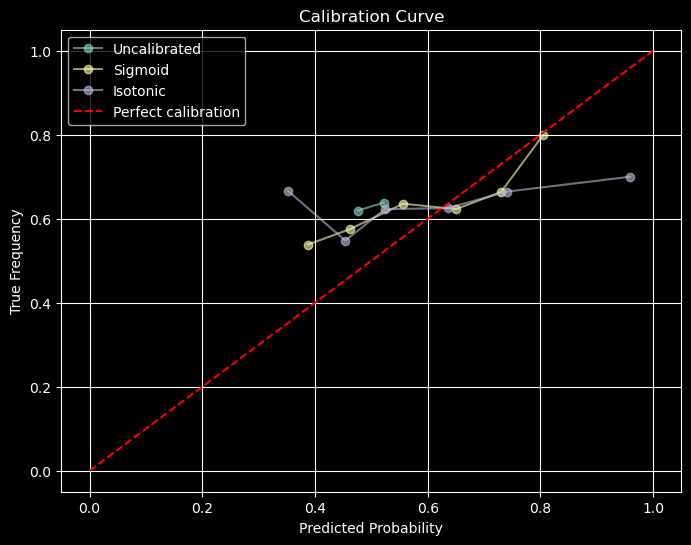

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator


clf.fit(X_train, y_train, sample_weight=weighting_schemes[best_scheme])

cal_sig = CalibratedClassifierCV(estimator=FrozenEstimator(clf), method="sigmoid", cv=cv_gen)
cal_sig.fit(X_train, y_train, sample_weight=weighting_schemes[best_scheme])

cal_iso = CalibratedClassifierCV(estimator=FrozenEstimator(clf), method="isotonic", cv=cv_gen)
cal_iso.fit(X_train, y_train, sample_weight=weighting_schemes[best_scheme])


# Get predictions
y_prob = clf.predict_proba(X_test)[:, 1]
y_prob_sig = cal_sig.predict_proba(X_test)[:, 1]
y_prob_iso = cal_iso.predict_proba(X_test)[:, 1]

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
prob_true_sig, prob_pred_sig = calibration_curve(y_test, y_prob_sig, n_bins=10)
prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_iso, n_bins=10)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', alpha=0.6)
plt.plot(prob_pred_sig, prob_true_sig, marker='o', label='Sigmoid', alpha=0.6)
plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Frequency')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)


```

**How to read it:**
- **Points on diagonal** → Well calibrated
- **Points above diagonal** → Underconfident (predicts lower than reality)
- **Points below diagonal** → Overconfident (predicts higher than reality)

---

### **2. Expected Calibration Error (ECE)**

**Formula**:
```
ECE = Σ (n_k / n) * |acc_k - conf_k|